In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from matplotlib.patches import Ellipse

In [3]:
sys.path.insert(0, '/home/aew492/CFE_gradients/code')
import load_tools
import globals
globals.initialize_vals()
data_dir = globals.data_dir

In [4]:
def grad_input(grad_dim, cat_tag, rlz=0, m=1, b=0.5):
    mock_dict = np.load(os.path.join(data_dir, f'gradient/{grad_dim}D/mock_data/{cat_tag}/{cat_tag}_rlz{rlz}_m-{m:.3f}-L_b-{b:.3f}.npy'), allow_pickle=True).item()
    return mock_dict['grad_expected']

# 1D

In [5]:
# mock parameters
Ls = [750, 1000, 1500]
ms = [1]
n = '1e-4'
b = 0.5
cat_tags = [f'L{L}_n{n}_z057_patchy_As2x' for L in Ls]

In [6]:
# load in recovered amplitudes
amps_1D = np.empty((len(ms), len(Ls), 401, 4))  # array to hold amplitudes for different strengths and boxsizes
for i, m in enumerate(ms):
    for j, L in enumerate(Ls):
        amps_1D[i,j] = load_tools.load_suave_amps(cat_tags[j], m=m, grad_dim=1, basis='bao_fixed')

In [7]:
# mean a_0s
mean_a0s = np.zeros(len(Ls))
for i in range(len(Ls)):
    mean_a0s[i] = np.mean(amps_1D[0,i,:,0]) # mean a_0 over 401 rlzs with m=1

In [8]:
mean_a0s

array([0.95390599, 0.95590125, 0.95765333])

In [9]:
# divide spatial components by dimensionless a_0 to get our recovered gradient vector
grads_rec_1D = (amps_1D[:,:,:,1:].T/amps_1D[:,:,:,0].T).T
grads_rec_1D.shape

(1, 3, 401, 3)

In [10]:
# median recovered gradient, to center ellipse
grad_rec_1D_medians = np.median(grads_rec_1D, axis=2)
grad_rec_1D_medians.shape

(1, 3, 3)

In [11]:
# standard deviations
stds_1D = np.std(grads_rec_1D, axis=2)
stds_1D.shape

(1, 3, 3)

In [12]:
stds_1D

array([[[3.43090256e-04, 4.59827747e-04, 4.75473788e-04],
        [1.65335216e-04, 2.42382385e-04, 2.26495744e-04],
        [5.63470185e-05, 8.28507314e-05, 8.24232432e-05]]])

In [13]:
# input/expected gradient
grads_input_1D = np.empty(grad_rec_1D_medians.shape)
for i, cat_tag in enumerate(cat_tags):
    grads_input_1D[:,i,:] = grad_input(1, cat_tag, m=m, b=b)

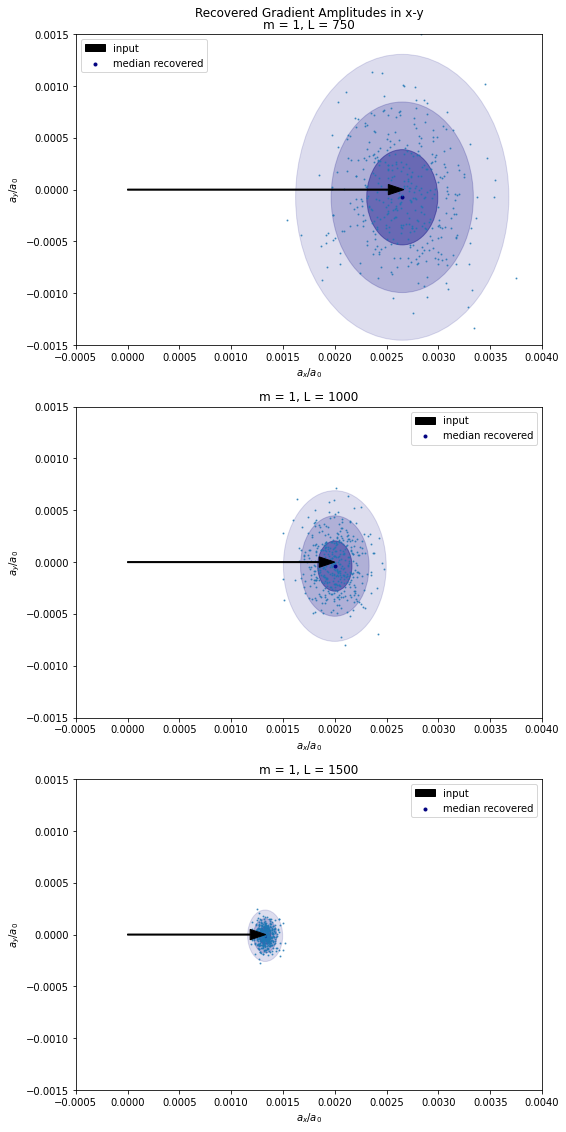

In [24]:
fig, axs = plt.subplots(len(Ls), figsize=(10,16))
for i, m in enumerate(ms):
    for j, L in enumerate(Ls):
        # plot individual realizations
        axs[j].plot(grads_rec_1D[i,j,:,0], grads_rec_1D[i,j,:,1], marker='.', markersize=2, ls='None', alpha=0.7)
        # input gradient arrow
        axs[j].arrow(0,0,grads_input_1D[i,j,0], grads_input_1D[i,j,1], color='k', length_includes_head=True, width=0.00001, head_width=0.0001,label='input',zorder=100)
        # ellipse: spread of recovered amplitudes, centered at the median recovered gradient
        axs[j].scatter(grad_rec_1D_medians[i,j,0], grad_rec_1D_medians[i,j,1], color='navy', marker='.', label='median recovered')
        for k in range(1,4):
            ellipse = Ellipse(xy=(grad_rec_1D_medians[i,j,0], grad_rec_1D_medians[i,j,1]), width=k*2*stds_1D[i,j,0], height=k*2*stds_1D[i,j,1], color='navy', fill=True, alpha=0.4/k)
            axs[j].add_patch(ellipse)

        # limits
        axs[j].set_aspect('equal')
        axs[j].set_xlim((-5e-4,4e-3))
        axs[j].set_ylim((-1.5e-3,1.5e-3))
        axs[j].set_title(f'm = {m}, L = {L}')
        axs[j].set_xlabel(r'$a_x / a_0$')
        axs[j].set_ylabel(r'$a_y / a_0$')
        axs[j].legend()

fig.suptitle(f'Recovered Gradient Amplitudes in x-y')
fig.tight_layout()

Sort of two things going on here:
* As $L$ increases, we recover the input gradient more precisely
* As $L$ increases, the gradient becomes weaker, i.e. in the 1D case $a_x/a_0$ decreases

### 2D

In [25]:
# mock parameters
cat_tag = 'L1000_n2e-4_z057_patchy_As2x'
m = 1
b = 0.5

amps_2D = load_tools.load_suave_amps(cat_tag, m=m, grad_dim=2, basis='bao_fixed')

In [26]:
# input gradient vector
grad_input_2D = grad_input(2, cat_tag, m=m, b=b)

In [27]:
grad_input_2D

array([0.00141421, 0.00141421, 0.        ])

In [28]:
# recovered gradient vector: divide amplitudes (a_x, a_y, a_z)/a_0
grads_rec_2D = (amps_2D[:,1:].T/amps_2D[:,0].T).T
grads_rec_2D.shape

(401, 3)

In [29]:
# median recovered gradient, to center ellipse
grad_rec_2D_median = np.median(grads_rec_2D, axis=0)
grad_rec_2D_median

array([1.35269087e-03, 1.34601068e-03, 5.38529299e-07])

In [30]:
# standard deviations
stds_2D = np.std(grads_rec_2D, axis=0)
stds_2D.shape

(3,)

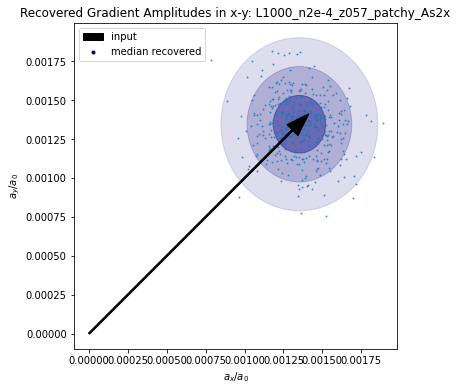

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(grads_rec_2D[:,0], grads_rec_2D[:,1], marker='.', markersize=2, ls='None', alpha=0.7)
ax.arrow(0,0,grad_input_2D[0], grad_input_2D[1], color='k', length_includes_head=True, width=0.00001, head_width=0.0001, label='input', zorder=100)
ax.scatter(grad_rec_2D_median[0], grad_rec_2D_median[1], color='navy', marker='.', label='median recovered')
for i in range(1,4):
    ellipse = Ellipse(xy=(grad_rec_2D_median[0], grad_rec_2D_median[1]), width=i*2*stds_2D[0], height=i*2*stds_2D[1], color='navy', fill=True, alpha=0.4/i)
    ax.add_patch(ellipse)

ax.set_aspect('equal')
ax.set_xlabel(r'$a_x / a_0$')
ax.set_ylabel(r'$a_y / a_0$')
ax.set_title(f'Recovered Gradient Amplitudes in x-y: {cat_tag}')
plt.legend()